In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
df = pd.read_excel("final_nhs-wq_pre_2023_compressed.xlsx")
cols_to_fix = ["NO3", "As (ppb)", "Fe (ppm)", "Total Hardness", "pH", "EC (µS/cm at"]
for col in cols_to_fix:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df[cols_to_fix] = df[cols_to_fix].fillna(df[cols_to_fix].median())
def water_quality_label(row):
    if (
        row["NO3"] > 45 or
        row["As (ppb)"] > 10 or
        row["Fe (ppm)"] > 0.3 or
        row["Total Hardness"] > 300 or
        row["pH"] < 6.5 or row["pH"] > 8.5 or
        row["EC (µS/cm at"] > 1500):
        return 1   # Unsafe
    else:
        return 0   # Safe

df["WaterQuality_Label"] = df.apply(water_quality_label, axis=1)
X = df.drop(columns=["WaterQuality_Label"])
y = df["WaterQuality_Label"]
X = X.select_dtypes(include=["float64", "int64"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
def disease_risk_mapping(row):
    risks = []
    if row["NO3"] > 45:
        risks.append("Blue Baby Syndrome (Methemoglobinemia)")
    if row["As (ppb)"] > 10:
        risks.append("Arsenic Poisoning (Skin, Cancer risk)")
    if row["Fe (ppm)"] > 0.3:
        risks.append("Stomach Issues / Teeth Staining")
    if row["Total Hardness"] > 300:
        risks.append("Hair Fall, Kidney Stones")
    if row["pH"] < 6.5 or row["pH"] > 8.5:
        risks.append("Diarrhea, Stomach Irritation")
    if row["EC (µS/cm at"] > 1500:
        risks.append("Hypertension Risk (High Salinity)")
    return ", ".join(risks) if risks else "Safe"
df["Possible_Diseases"] = df.apply(disease_risk_mapping, axis=1)
df["Final_Health_Status"] = df.apply(
    lambda row: "Unsafe: " + row["Possible_Diseases"] if row["WaterQuality_Label"] == 1
    else "Safe", axis=1)
df.to_csv("NE_WaterQuality_Final.csv", index=False)


✅ Model Accuracy: 0.9994040524433849

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1437
           1       1.00      1.00      1.00      1919

    accuracy                           1.00      3356
   macro avg       1.00      1.00      1.00      3356
weighted avg       1.00      1.00      1.00      3356


Confusion Matrix:
 [[1437    0]
 [   2 1917]]


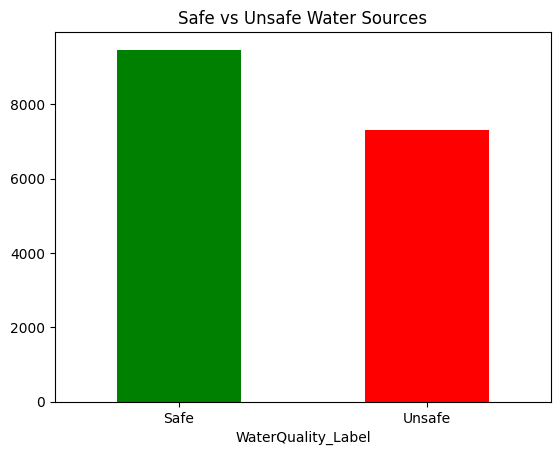

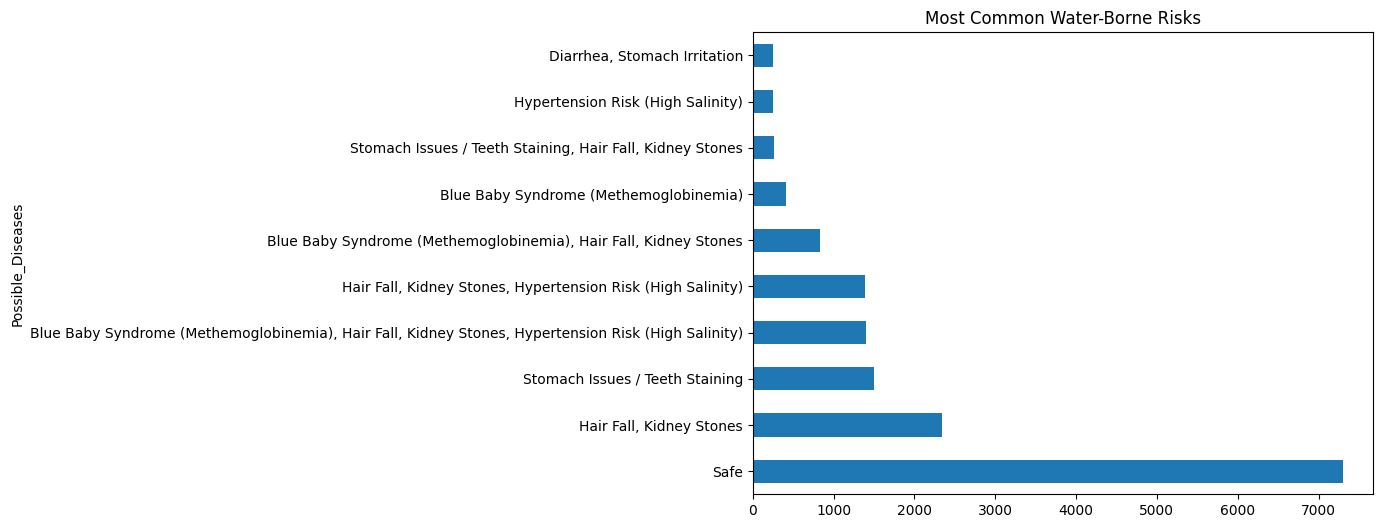

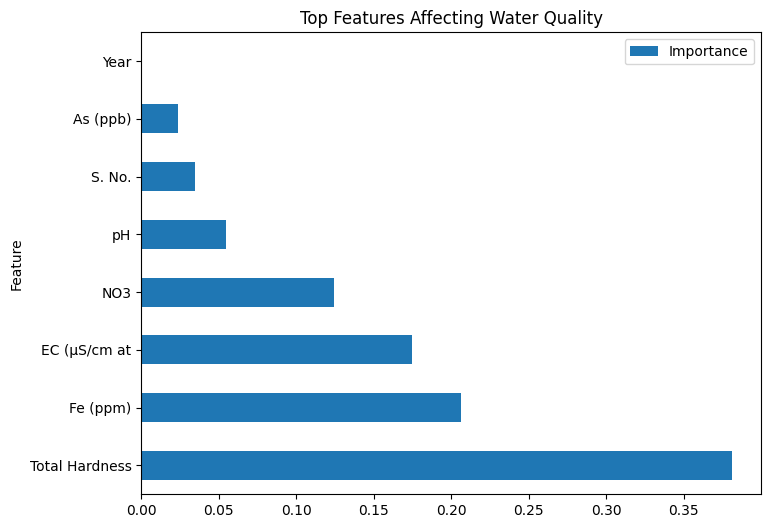

In [ ]:
import matplotlib.pyplot as plt
df["WaterQuality_Label"].value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Safe vs Unsafe Water Sources")
plt.xticks([0,1], ["Safe", "Unsafe"], rotation=0)
plt.show()
disease_counts = df["Possible_Diseases"].value_counts().head(10)
disease_counts.plot(kind="barh", figsize=(8,6))
plt.title("Most Common Water-Borne Risks")
plt.show()
importances = model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df.sort_values(by="Importance", ascending=False).head(10).plot(
    x="Feature", y="Importance", kind="barh", figsize=(8,6))
plt.title("Top Features Affecting Water Quality")
plt.show()
